In [425]:
import sys
from pathlib import Path 
sys.path.append(str(Path.cwd().parent.parent))
import numpy as np
from kymatio.scattering2d.core.scattering2d import scattering2d
import matplotlib.pyplot as plt
import torch
import torchvision
from kymatio import Scattering2D
from . import functional as F
from PIL import Image
from IPython.display import display 
from torchvision.transforms import *
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import pandas as pd

In [428]:
F.affine

<function torchvision.transforms.functional.affine(img: torch.Tensor, angle: float, translate: List[int], scale: float, shear: List[float], interpolation: torchvision.transforms.functional.InterpolationMode = <InterpolationMode.NEAREST: 'nearest'>, fill: Union[List[float], NoneType] = None, resample: Union[int, NoneType] = None, fillcolor: Union[List[float], NoneType] = None) -> torch.Tensor>

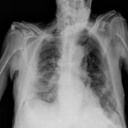

In [365]:
#img = Image.open('/NOBACKUP/gauthiers/KTH/sample_a/wood/54a-scale_10_im_10_col.png')
img = Image.open('/NOBACKUP/gauthiers/chest_xrays_preprocess/train/positive/MIDRC-RICORD-1C-SITE2-000216-21074-0.png')
rsz_transf = torchvision.transforms.Resize((128,128))
img = rsz_transf(img)
display(img)

# 1. Rotation

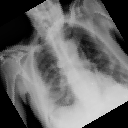

In [292]:
transformation = torchvision.transforms.RandomRotation(degrees = [30,30])
img_rot2 = transformation(img)
display(img_rot2)

# 2. Gaussian Blur

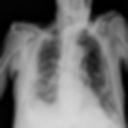

In [294]:
transformation = torchvision.transforms.GaussianBlur(21)
img_blur = transformation(img)
display(img_blur)

# 3. Distortion

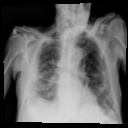

In [301]:
transforms = torchvision.transforms.RandomPerspective(distortion_scale=0.1, p=1)
img_1 = transforms(img)
display(img_1)


# 4. Shear

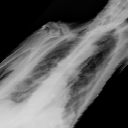

In [338]:
a= 40
transforms = torchvision.transforms.RandomAffine(degrees = 0, shear=[a,a])
img_2 = transforms(img)
display(img_2)


# 5. Horizontal & Vertical Translation

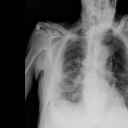

In [426]:
v =25
transforms = torchvision.transforms.RandomAffine(degrees = 0, translate=[0,0])
ret = transforms.get_params(transforms.degrees, transforms.translate, transforms.scale, transforms.shear, (128,128))
ret = list(ret)
ret[1] = (v,0)
ret= tuple(ret)

img_2 = F.affine(img, *ret, interpolation=transforms.interpolation, fill=False)
display(img_2)

# 6. Sharpness

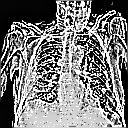

In [418]:
transforms = torchvision.transforms.RandomAdjustSharpness(sharpness_factor=100, p=0.5)
img_2 = transforms(img)
display(img_2)


Elastic Deformation

In [121]:
def Elastic_transform(image, alpha, sigma):
    shape = image.shape
    shape_size = shape[:2]
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

À la Mallat

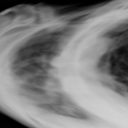

CPU times: user 663 ms, sys: 3.29 ms, total: 666 ms
Wall time: 665 ms


In [13]:
%%time
# def tau(u):
#     print(u)
#     return [0.5*u[0]+0.5*u[1]**2,0.3*u[1]]
#tau = lambda u : 0.2*u
#tau = lambda u : [0.5*u[0]+0.5*u[1]**2,0.3*u[1]] #la fonction tau de Mallat
#tau_mat = lambda u : torch.tensor([[vectorize_tau(grid)] for j in range(len(u))] for i in range(len(u))]) #dim x dim x 2
# vectorize_tau = lambda grid : np.vectorize(tau)(grid) #dim x dim x 2   
tau = lambda grid : torch.tensor([[[0.5*grid[i,j,0]+0.5*grid[i,j,1]**2,0.3*grid[i,j,1]] for j in range(len(grid))] for i in range(len(grid))])
def diffeo(img,tau):
    transf = torchvision.transforms.ToTensor()
    img = transf(img).unsqueeze(0)
    dim = img.shape[-1]
    grid = torch.tensor([[[x,y] for x in torch.linspace(-1,1,dim)] for y in torch.linspace(-1,1,dim)])
    grid_transf = (grid - tau(grid)).unsqueeze(0)
    img_transf = torch.nn.functional.grid_sample(img,grid_transf).squeeze(0)
    transf = torchvision.transforms.ToPILImage()
    return transf(img_transf)
img_diffeo = diffeo(img,tau)
display(img_diffeo)